# Load and plot results from eval script runs

In [1]:
from importlib import reload

import copy
import matplotlib.pyplot as plt
import pickle
import numpy as np

from pprint import pprint


from adaptive_time import plot_utils
from adaptive_time import utils

plot_utils = reload(plot_utils)
utils = reload(utils)

In [2]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

## Load and Explore the Data

In [3]:
# Real evaluation experiment:
res_file_path = "exp_results/old/tradeoff_results_20240228-144710.pkl"

# Just a test:
# res_file_path = "exp_results/20240229-094504_test-new-save-scheme/exp_data.pkl"

# MAKE SURE THIS IS THE SAME AS IN code/adaptive_time/notebooks/policy_eval_ground_truth.ipynb
base_policy_returns = [13811.823415783701, 26.83463996869155]

with open(res_file_path, "rb") as f:
    loaded = pickle.load(f)
    if "results" in loaded:
        results = loaded["results"]
        print("The config for these results was: ")
        pprint(loaded["config"])
        policy_prob = loaded["config"]["policy_to_evaluate"][2]
    else:
        results = loaded
        policy_prob = None
        print("Could not find a config.")

if policy_prob:
    expected_return = np.dot(base_policy_returns, [policy_prob, 1.0 - policy_prob])
    print()
    print("expected_return:", expected_return)

The config for these results was: 
{'budget': 50000,
 'budget_type': <BudgetType.UPDATES: 2>,
 'do_weighing': True,
 'epsilon': 0.0,
 'gamma': 0.99999,
 'max_env_steps': None,
 'num_runs': 5,
 'policy_to_evaluate': ('/Users/szepi1991/Code/adaptive_time/policy_to_eval_good.npy',
                        '/Users/szepi1991/Code/adaptive_time/policy_to_eval_bad.npy',
                        0.5),
 'save_limit': None,
 'seed': 13,
 'tau': 0.02,
 'termination_prob': 0,
 'weights_to_evaluate': None}

expected_return: 6919.329027876196


In [4]:
results.keys()

dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])

In [5]:
_first_el = list(results.values())[0]
print("number of runs:", len(_first_el))

number of runs: 5


In [6]:
print("recorded stats:")
pprint(list(_first_el[0].keys()))

recorded stats:
['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v']


In [7]:
print("Numbers of episodes:")
max_episodes = 0
for name, runs_data in results.items():
    num_episodes = [len(run["returns_per_episode_v"]) for run in runs_data]
    max_episodes = max(max_episodes, max(num_episodes))
    print(f" * {name}: {num_episodes}")

Numbers of episodes:
 * q0_10: [2070, 2076, 2024, 2095, 2052]
 * q0_5: [1270, 1308, 1279, 1289, 1300]
 * q0_1: [48, 41, 46, 46, 65]
 * u5: [39, 26, 36, 33, 41]
 * u10: [64, 59, 65, 75, 84]
 * u20: [143, 143, 134, 141, 146]


In [8]:
expected_return

6919.329027876196

#### Detailed Exploration

In [9]:
pprint(np.stack(results["u5"][0]["returns_per_episode_v"]))

array([13811.82341578,    26.83463997, 13811.82341578, 13811.82341578,
          26.83463997, 13811.82341578, 13811.82341578,    26.83463997,
          26.83463997,    26.83463997,    26.83463997, 13811.82341578,
       13811.82341578,    26.83463997,    26.83463997,    26.83463997,
          26.83463997, 13811.82341578,    26.83463997,    26.83463997,
          26.83463997, 13811.82341578,    26.83463997,    26.83463997,
       13811.82341578,    26.83463997, 13811.82341578,    26.83463997,
       13811.82341578,    26.83463997,    26.83463997,    26.83463997,
          26.83463997, 13811.82341578, 13811.82341578, 13811.82341578,
          26.83463997, 13811.82341578, 13811.82341578])


In [10]:
pprint(np.stack(results["u5"][0]["predicted_returns_v"]))

array([16996.69154068, 11937.4936339 , 13641.94717431, 14005.72096876,
       11767.97097694, 12244.81104488, 12485.083564  , 11158.82563514,
       10044.7751037 ,  9116.56225868,  8337.9549018 ,  8807.37304621,
        9174.11176231,  8556.32297478,  8013.63658007,  7533.98785584,
        7107.46890319,  7457.75192972,  7079.00132182,  6736.34885722,
        6424.9950734 ,  6733.91955892,  6449.30135114,  6187.57718588,
        6462.00429753,  6219.6396212 ,  6466.9639927 ,  6241.47952354,
        6466.69027782,  6256.0218645 ,  6058.56643982,  5873.13664682,
        5698.680164  ,  5904.09113211,  6095.05795014,  6273.16662345,
        6106.86772451,  6273.54672518,  6430.12013317])


In [11]:
pprint(np.stack(results["u5"][0]["returns_per_episode_q"]))

array([[13811.82341578,            nan],
       [           nan,    26.83463997],
       [13811.82341578,            nan],
       [13811.82341578,            nan],
       [           nan,    26.83463997],
       [13811.82341578,            nan],
       [13811.82341578,            nan],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [13811.82341578,            nan],
       [13811.82341578,            nan],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [13811.82341578,            nan],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [13811.82341578,            nan],
       [           nan,    26.83463997],
       [           nan,    26.83463997],
       [13811.82

In [12]:
pprint(np.stack(results["u5"][0]["predicted_returns_q"]))

array([[16996.69154068, 26351.18053944],
       [17015.72298816,  6859.26427964],
       [15917.46268469,  9090.91615355],
       [15236.20842464, 10314.25860111],
       [15236.18263846,  6565.65348465],
       [14762.28439631,  7209.86434203],
       [14409.51561332,  7674.00344071],
       [14409.51833357,  5741.00447109],
       [14409.51970754,  4588.8443489 ],
       [14409.52053646,  3823.60398091],
       [14409.52109093,  3278.31641085],
       [14134.84183667,  3479.90425575],
       [13913.94694198,  3644.30405269],
       [13913.94826035,  3198.69768922],
       [13913.94925064,  2850.86299331],
       [13913.95002161,  2571.79506025],
       [13913.95063894,  2342.93168816],
       [13731.92744661,  2438.41151622],
       [13731.92807868,  2240.50913502],
       [13731.92860586,  2072.62902478],
       [13731.92905214,  1928.42031725],
       [13579.04266727,  1994.98817621],
       [13579.04311416,  1865.89593206],
       [13579.04350148,  1752.69739652],
       [13448.63

In [13]:
pprint(np.stack(results["q0_5"][0]["predicted_returns_q"]))

array([[ 1.38115634e+04, -5.55241788e+04],
       [ 1.38115556e+04, -2.13184898e+02],
       [ 1.38116314e+04, -3.48166011e+02],
       ...,
       [ 1.38118075e+04,  3.47962373e+01],
       [ 1.38118075e+04,  3.48014037e+01],
       [ 1.38118075e+04,  3.48065578e+01]])


In [14]:
pprint(np.stack(results["q0_5"][0]["predicted_returns_v"]))

array([13811.56337066,  6799.18534457,  9091.69894238, ...,
        7118.87458403,  7124.15128034,  7129.41966098])


## Plotting Code -- INSTRUCTIONS

By default we load the plotting code from `plot_utils.py`, but feel
free to overwrite these below.

In [15]:
plot_stuff = plot_utils.plot_stuff
default_plot_per_run_from_dict = plot_utils.default_plot_per_run_from_dict
default_plot_per_run_from_procdata = plot_utils.default_plot_per_run_from_procdata
default_plot_mean_from_proc_data = plot_utils.default_plot_mean_from_proc_data


def plot_stuff_with_errs(
      tuples_of_x_y_errs_labels_kwargs, title, ylabel, show):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x, y, yerr, label, kwargs in tuples_of_x_y_errs_labels_kwargs:
        plt.errorbar(x, y, yerr, label=label, **kwargs)

    plt.ylabel(ylabel, rotation=0, labelpad=40)
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax



## Plots of Average Behaviour

In [17]:
pred_rets_data = plot_utils.process_across_runs(
        results, "total_pivots", "predicted_returns_v", right=np.nan)


/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:64: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


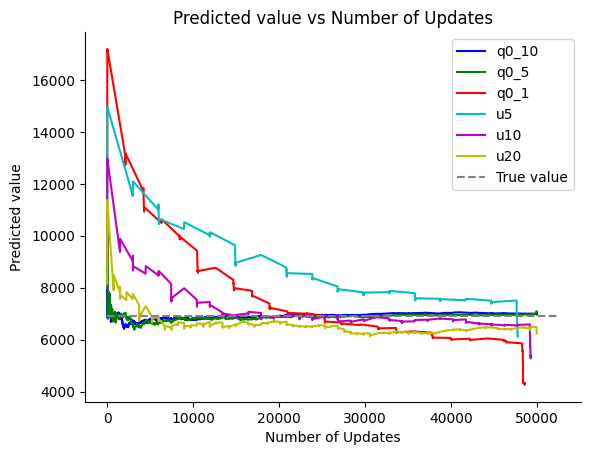

In [18]:

ax = default_plot_mean_from_proc_data(
    pred_rets_data, "Number of Updates", "Predicted value", show=False
)

min_x, max_x = ax.get_xlim()
plt.hlines(
    expected_return, 0, max_x,
    colors='grey', linestyles='dashed',
    label='True value')
ax.legend()
# ax.set_xlim(-100, 2000)
# ax.set_yscale('log')
plt.show()


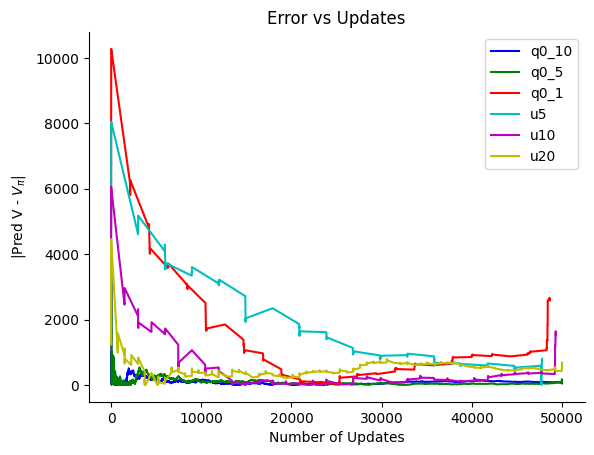

In [19]:
_means = {
    k: np.abs(val - expected_return)
    for k, val in pred_rets_data.means.items()
}
error_data = pred_rets_data._replace(means=_means)

ax = default_plot_mean_from_proc_data(
    error_data, "Number of Updates", "|Pred V - $V_\pi$|",
    title="Error vs Updates", show=False
)

# ax.set_xlim(-100, 2000)
# ax.set_yscale('log')
plt.show()

## Plots of individual runs

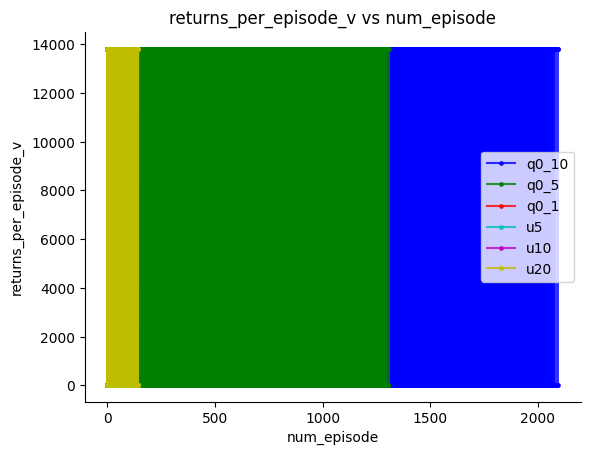

<Axes: title={'center': 'returns_per_episode_v vs num_episode'}, xlabel='num_episode', ylabel='returns_per_episode_v'>

In [20]:
default_plot_per_run_from_dict(
        results, x_label="num_episode", y_label="returns_per_episode_v")


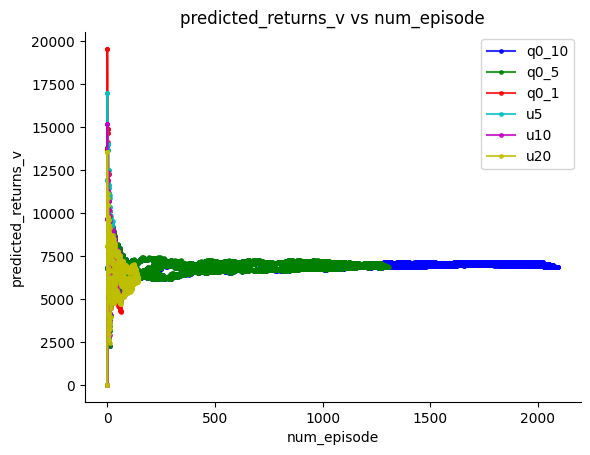

<Axes: title={'center': 'predicted_returns_v vs num_episode'}, xlabel='num_episode', ylabel='predicted_returns_v'>

In [21]:
default_plot_per_run_from_dict(
        results, x_label="num_episode", y_label="predicted_returns_v")


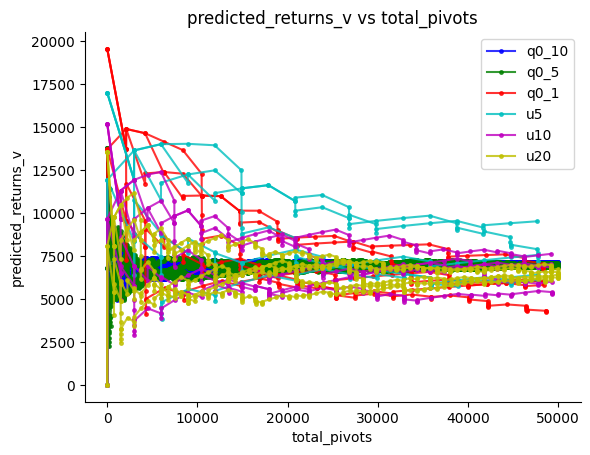

<Axes: title={'center': 'predicted_returns_v vs total_pivots'}, xlabel='total_pivots', ylabel='predicted_returns_v'>

In [22]:
default_plot_per_run_from_dict(
        results, x_label="total_pivots", y_label="predicted_returns_v")
